### Fasion-MNIST 데이터 셋 분류하기

#### 패키지 준비

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets.mnist import load_data

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

#### 데이터 셋 준비하기

In [2]:
# 데이터 로드

(x_train, y_train), (x_test, y_test) = load_data()
print(f'훈련 데이터 {x_train.shape} 레이블 {y_train.shape}')
print(f'검증 데이터 {x_test.shape} 레이블 {y_test.shape}')

훈련 데이터 (60000, 28, 28) 레이블 (60000,)
검증 데이터 (10000, 28, 28) 레이블 (10000,)


In [3]:
# 종속변수 값 정의

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#### EDA

In [4]:
# 임의의 샘플값 확인

for i in x_train[1]:
    for j in i:
        print("%03d" % j, end="")
    print()

000000000000000000000000000000000000000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000051159253159050000000000000000000000000
000000000000000000000000000000000000000000048238252252252237000000000000000000000000
000000000000000000000000000000000000000054227253252239233252057006000000000000000000
000000000000000000000000000000000010060224252253252202084252253122000000000000000000
000000000000000000000000000000000163252252252253252252096189253167000000000000000000
000000000000000000000000000000051238253253190114253228047079255168000000000000000000
000000000000000000000000000048238252252179012075121021000000253243050000000000000000
00000000000000000000000003816525323320808400000000000000000025325

In [5]:
# 샘플에 대한 종속변수 확인

y = y_train[1]
yname = class_names[y]
print(y, " >> ", yname)

0  >>  T-shirt/top


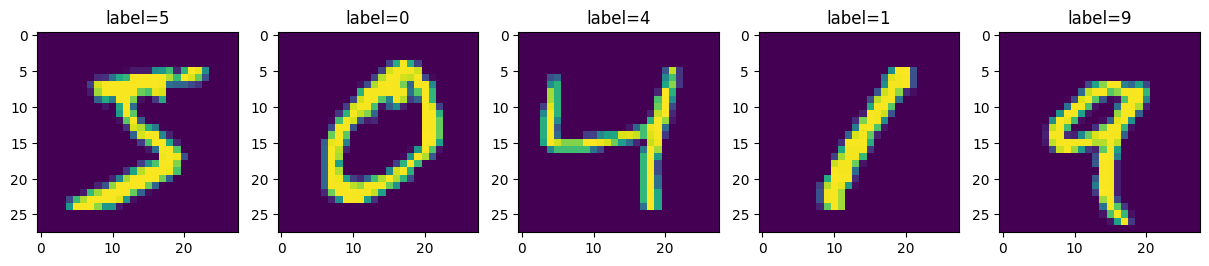

In [6]:
# 데이터 그려보기

fig, ax = plt.subplots(1, 5, figsize=(15, 3), dpi=100)

for i in range(0, len(ax)):
    train = x_train[i]
    label = y_train[i]
    ax[i].imshow(train)
    ax[i].set_title("label=%d" % label)

#### 데이터셋 분할하기

In [7]:
# 랜덤시드 고정

np.random.seed(777)

In [8]:
# 레이블에 대한 one-hot-encoding

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
print(y_test_one_hot)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [9]:
# 훈련, 검증용 독립변수(이미지)의 차수 재설정

x_train_reshape = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test_reshape = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print(f'훈련 데이터 {x_train_reshape.shape} / 검증 데이터 {x_train_reshape.shape}')

훈련 데이터 (60000, 28, 28, 1) / 검증 데이터 (60000, 28, 28, 1)


#### 모델개발

In [10]:
# 모델정의

model = Sequential()

# Conv2D
model.add(Conv2D(filters=32, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=(28, 28, 1)))

# 표준화
model.add(BatchNormalization())

# MaxPool2D
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# 랜덤으로 25%의 뉴런을 쉬게함
model.add(Dropout(0.25))

# 이전보다 filter는 크게, kelnel_size는 작게, input_shape는 최초에만 적용하므로 여기서는 생략
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# 1차원으로 변환하기 위한 Layer
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

# 최종 아웃풋의 수는 one_hot_encoding의 원소 수 만큼
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

In [11]:
# 학습하기

result = model.fit(x_train_reshape, y_train_one_hot, epochs=500, validation_data=(x_test_reshape, y_test_one_hot), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

result_df = pd.DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)
result_df

Epoch 1/500
1875/1875 [==============================] - 90s 48ms/step - loss: 0.1458 - acc: 0.9561 - val_loss: 0.0696 - val_acc: 0.9784
Epoch 2/500
1875/1875 [==============================] - 105s 56ms/step - loss: 0.0635 - acc: 0.9816 - val_loss: 0.0865 - val_acc: 0.9791
Epoch 3/500
1875/1875 [==============================] - 109s 58ms/step - loss: 0.0525 - acc: 0.9844 - val_loss: 0.0385 - val_acc: 0.9895
Epoch 4/500
1875/1875 [==============================] - 100s 54ms/step - loss: 0.0438 - acc: 0.9874 - val_loss: 0.0353 - val_acc: 0.9898
Epoch 5/500
1875/1875 [==============================] - 98s 52ms/step - loss: 0.0366 - acc: 0.9898 - val_loss: 0.0471 - val_acc: 0.9875
Epoch 6/500
1875/1875 [==============================] - 107s 57ms/step - loss: 0.0354 - acc: 0.9909 - val_loss: 0.0356 - val_acc: 0.9906
Epoch 7/500
1875/1875 [==============================] - 101s 54ms/step - loss: 0.0326 - acc: 0.9916 - val_loss: 0.0392 - val_acc: 0.9903

Epoch 00007: ReduceLROnPlateau redu

,loss,acc,val_loss,val_acc,lr
epochs,,,,,
1,0.145753,0.956117,0.069648,0.9784,0.001000
2,0.063473,0.981617,0.086477,0.9791,0.001000
3,0.052452,0.984383,0.038453,0.9895,0.001000
4,0.043849,0.987417,0.035343,0.9898,0.001000
5,0.036577,0.989817,0.047054,0.9875,0.001000
6,0.035404,0.990950,0.035557,0.9906,0.001000
7,0.032622,0.991567,0.039245,0.9903,0.001000
8,0.016169,0.995500,0.031120,0.9917,0.000500
9,0.012357,0.996350,0.027610,0.9935,0.000500


#### 학습결과 평가

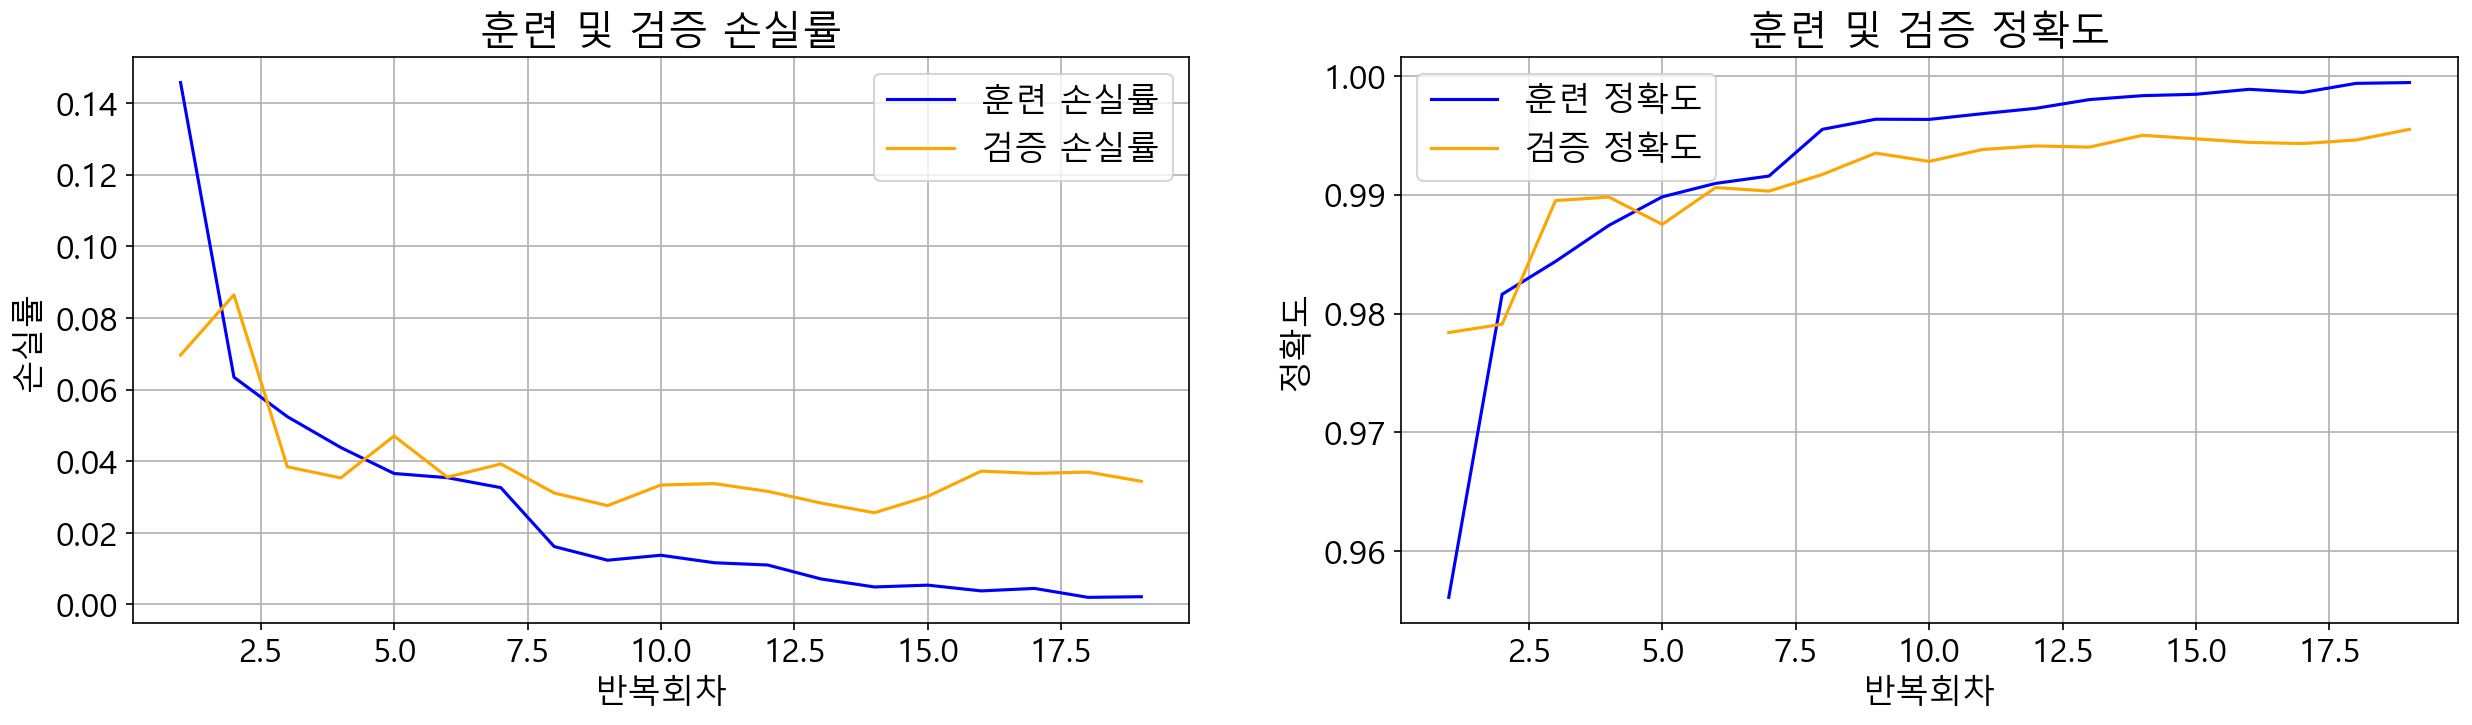

In [12]:
# 학습 결과 시각화

# 그래프 기본 설정
# ----------------------------------------
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
# ----------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), dpi=150)

# 1) 훈련 및 검증 손실 그리기
# ----------------------------------------
sns.lineplot(x=result_df.index, y='loss', data=result_df, color='blue', label='훈련 손실률', ax=ax1)
sns.lineplot(x=result_df.index, y='val_loss', data=result_df, color='orange', label='검증 손실률', ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()

# 2) 훈련 및 정확도 그리기
# ----------------------------------------
sns.lineplot(x=result_df.index, y='acc', data=result_df, color = 'blue', label = '훈련 정확도', ax=ax2)
sns.lineplot(x=result_df.index, y='val_acc', data=result_df, color = 'orange', label = '검증 정확도', ax=ax2)
ax2.set_title('훈련 및 검증 정확도')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

In [13]:
# 모델 성능평가

evaluate = model.evaluate(x_test_reshape, y_test_one_hot)
print("최종 손실률: %f, 최종 정확도: %f" % (evaluate[0], evaluate[1]))

313/313 [==============================] - 4s 13ms/step - loss: 0.0344 - acc: 0.9955
최종 손실률: 0.034397, 최종 정확도: 0.995500


#### 학습 결과 적용

In [15]:
# 테스트 데이터에 대한 예측결과 산정

result = model.predict(x_test_reshape)
data_count, case_count = result.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
result[0]

10000개의 검증 데이터가 10개의 경우의 수를 갖는다.


array([0.0000000e+00, 2.2780672e-35, 3.7943518e-33, 2.4945714e-28,
       4.4885865e-29, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
       2.4916261e-33, 3.0762090e-25], dtype=float32)

In [16]:
# 가장 큰 확률 값의 인덱스를 별도 리스트로 추출

arg_result = np.argmax(result, axis=-1)
arg_result

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

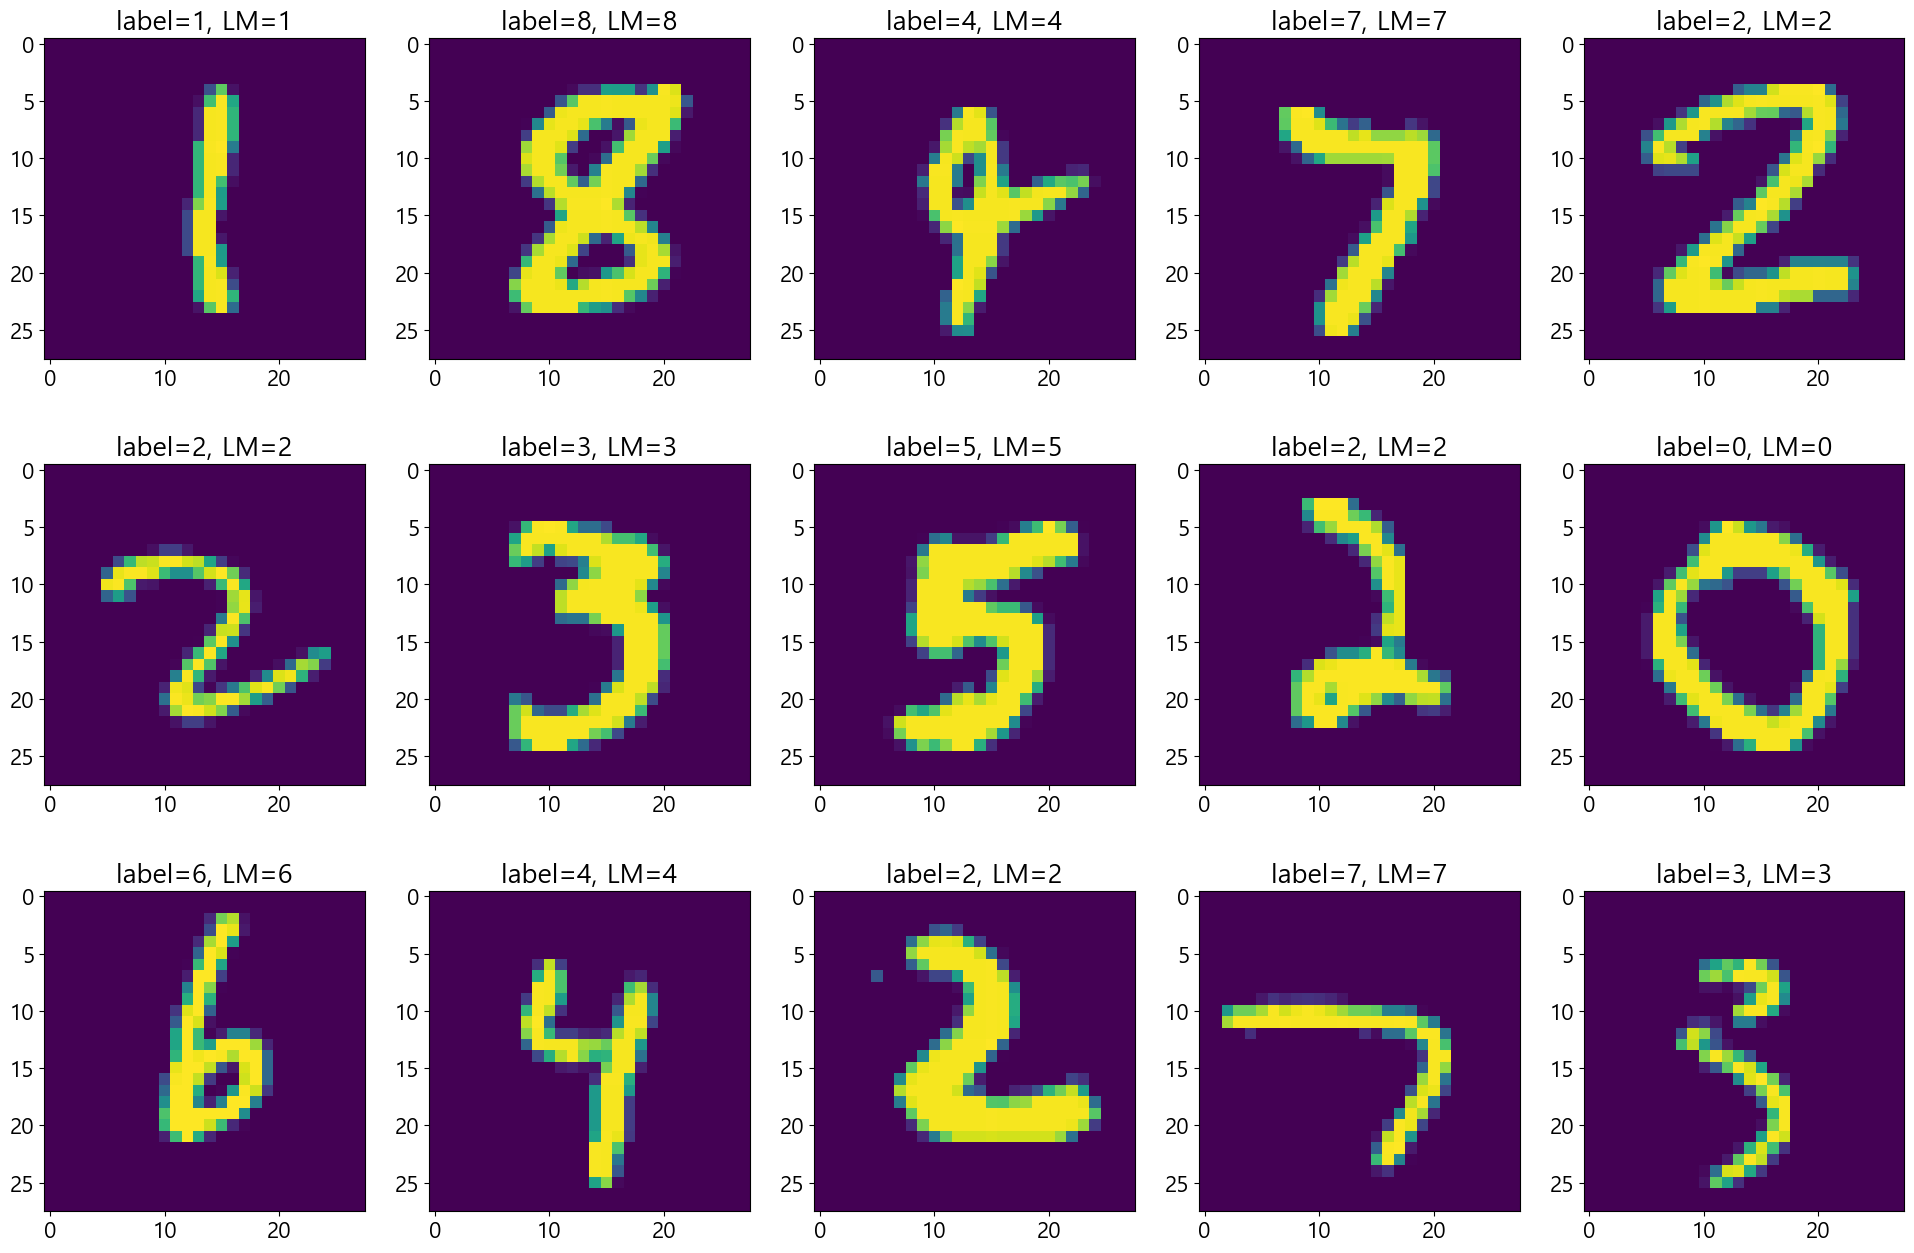

In [17]:
# 데이터 비교

row = 3
col = 5
fig, ax = plt.subplots(row, col, figsize=((col+1)*4, (row+1)*4), dpi=100)

size = row*col
length = len(y_test)

for i in range(0, size):
    k = np.random.randint(length)
    train = x_test[k]
    label = y_test[k]
    ax[i//col][i%col].imshow(train)
    ax[i//col][i%col].set_title("label=%d, LM=%d" % (label, arg_result[k]))

In [18]:
# 혼돈행렬

cm = confusion_matrix(y_test, arg_result)
cmdf2 = pd.DataFrame(cm, columns=list(map(lambda x: "실제값(%d)" % x, range(10))), index=list(map(lambda x: "예측값(%d)" % x, range(10))))
cmdf2

,실제값(0),실제값(1),실제값(2),실제값(3),실제값(4),실제값(5),실제값(6),실제값(7),실제값(8),실제값(9)
예측값(0),978,0,1,0,0,0,0,1,0,0
예측값(1),0,1134,0,0,0,0,0,1,0,0
예측값(2),0,0,1027,1,0,0,0,4,0,0
예측값(3),0,0,2,1007,0,1,0,0,0,0
예측값(4),0,0,0,0,980,0,0,0,0,2
예측값(5),1,0,0,2,0,888,1,0,0,0
예측값(6),2,2,1,0,1,1,950,0,1,0
예측값(7),0,2,3,0,0,0,0,1022,1,0
예측값(8),1,0,1,1,0,1,0,1,968,1
예측값(9),0,0,0,0,6,1,0,0,1,1001


Text(130.77083333333331, 0.5, '예측값')

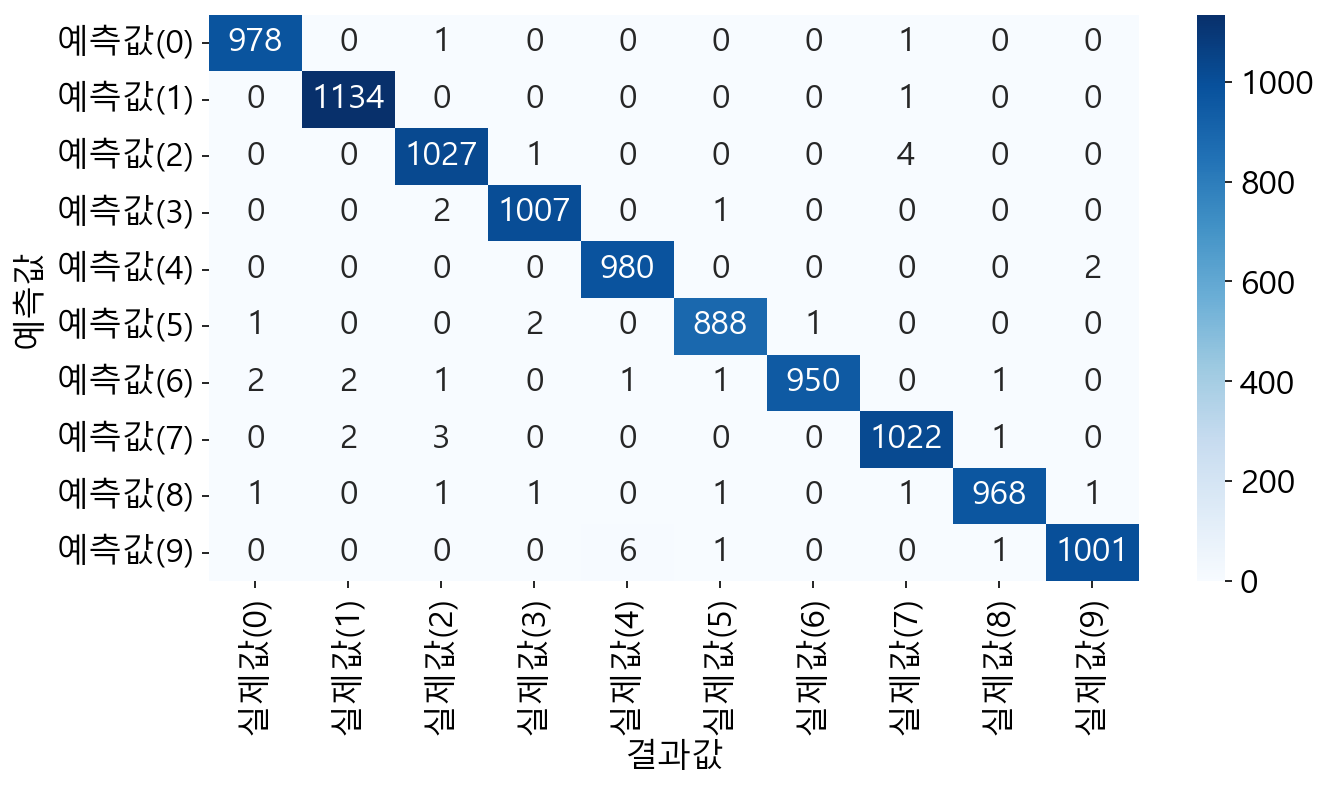

In [19]:
# 혼돈행렬 히트맵

fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=150)

# 오차 행렬을 히트맵 그래프로 표현
# -> annot : 그래프의 각 칸에 수치값 출력
# -> fmt : 수치값 출력 format (여기서는 10진수)
# -> cmap : 색상맵 (https://matplotlib.org/3.2.1/tutorials/colors/colormaps.html)
sns.heatmap(cmdf2, annot = True, fmt = 'd', cmap = 'Blues', ax=ax)
ax.set_xlabel('결과값')
ax.set_ylabel('예측값')
